# EMBEDDIG MIT LABSE

### TEXT CLUSTERUNG & TEXT CLASSIFICATION

In [ ]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 1.8MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.6-cp36-none-any.whl size=30318 sha256=c7db70987bb23765bc0f339e06deeb4f049ff6c1a91ab7deb5494a215c63fd20
  Stored in directory: /root/.cache/pip/wheels/07/a0/b4/75b0601ebaa41e517a797fe9cea119c789664c8408f8a74ae9
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=1775829909b530a92005919491804d3ced0c8ffbe1a52fd037e677dc87511c79
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=089bd714d3bc3aebe8cdf68957738150659b74c20cb443e1bac6d9568c40dd6b
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

def get_model(model_url, max_seq_length):
  labse_layer = hub.KerasLayer(model_url, trainable=True)

  # Define input.
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                     name="input_mask")
  segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="segment_ids")

  # LaBSE layer.
  pooled_output,  _ = labse_layer([input_word_ids, input_mask, segment_ids])

  # The embedding is l2 normalized.
  pooled_output = tf.keras.layers.Lambda(
      lambda x: tf.nn.l2_normalize(x, axis=1))(pooled_output)

  # Define model.
  return tf.keras.Model(
        inputs=[input_word_ids, input_mask, segment_ids],
        outputs=pooled_output), labse_layer

max_seq_length = 64
labse_model, labse_layer = get_model(
    model_url="https://tfhub.dev/google/LaBSE/1", max_seq_length=max_seq_length)


In [ ]:
import bert

vocab_file = labse_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = labse_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

def create_input(input_strings, tokenizer, max_seq_length):

  input_ids_all, input_mask_all, segment_ids_all = [], [], []
  for input_string in input_strings:
    # Tokenize input.
    input_tokens = ["[CLS]"] + tokenizer.tokenize(input_string) + ["[SEP]"]
    input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
    sequence_length = min(len(input_ids), max_seq_length)

    # Padding or truncation.
    if len(input_ids) >= max_seq_length:
      input_ids = input_ids[:max_seq_length]
    else:
      input_ids = input_ids + [0] * (max_seq_length - len(input_ids))

    input_mask = [1] * sequence_length + [0] * (max_seq_length - sequence_length)

    input_ids_all.append(input_ids)
    input_mask_all.append(input_mask)
    segment_ids_all.append([0] * max_seq_length)

  return np.array(input_ids_all), np.array(input_mask_all), np.array(segment_ids_all)

def encode(input_text):
  input_ids, input_mask, segment_ids = create_input(
    input_text, tokenizer, max_seq_length)
  return labse_model([input_ids, input_mask, segment_ids])

# CLUSTER SENTENCES

In [ ]:
def cluster_sentences(sentences):
    embeddings = encode(sentences)

    # Inner similarity
    #print (np.matmul(embeddings, np.transpose(embeddings)))

    import seaborn as sns

    corr = np.matmul(embeddings, np.transpose(embeddings))
    sns.set(font_scale=0.9)
    g = sns.clustermap(
          corr,
          xticklabels=sentences,
          yticklabels=sentences,
          vmin=0,
          vmax=1,
          cmap="YlOrRd")

    print("ALT")
    for i in range(len(sentences)):
      print(sentences[i])

    print("...")
    print("NEU")
    for i in range(len(sentences)):
      print(sentences[g.dendrogram_row.reordered_ind[i]])

ALT
Coca-Cola
Fanta
Sprite
Bier
Kindergarten
Schule
Hausaufgaben
Sportunterricht
Fußball
...
NEU
Hausaufgaben
Kindergarten
Schule
Sportunterricht
Fußball
Coca-Cola
Bier
Fanta
Sprite


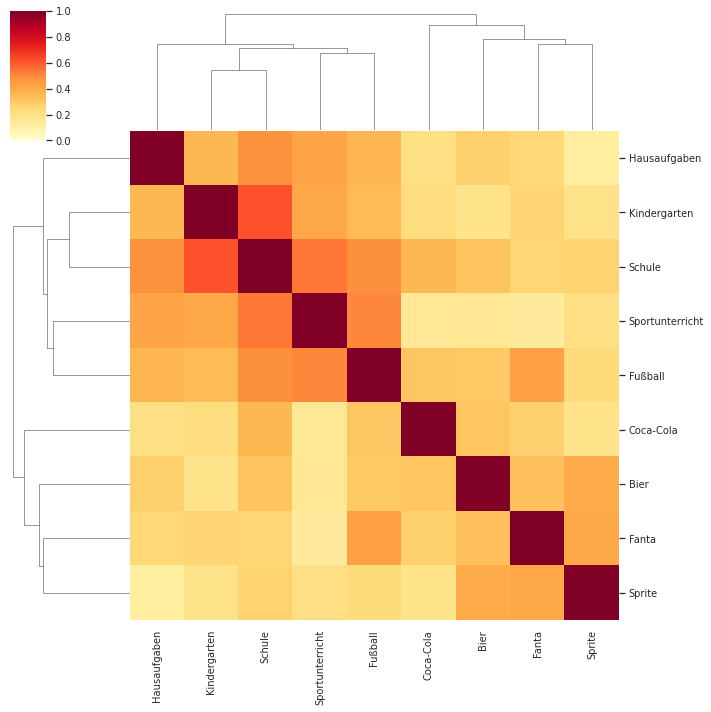

In [ ]:
sentences = ["Coca-Cola",
             "Fanta",
             "Sprite",
             "Bier",
             "Kindergarten",
             "Schule",
             "Hausaufgaben",
             "Sportunterricht",
             "Fußball"]

cluster_sentences(sentences)

# TEXT CLASSIFICATION

In [ ]:
def dummy_classifier(to_be_classified, konfidenz=0.50):

    sentences = ["Der Preis ist günstig",
                "Das Ticket ist zu teuer",
                "Mein Flug war ein Schnäppchen.",
                "Das Flugticket hat fast 500 Euro gekostet",
                "Der Flug hatte Verspätung",
                "Wir sind zu spät in London gelandet",
                "Wir sind 30 Minuten zu spät",
                "Ich war in letzter Zeit oft verspätet",
                "Das Essen war lecker, aber es gab zu wenig trinken :O",
                "Der Kaffee war kalt. Es gab kein Bier mehr.",
                "Die Pasta war zu salzig",
                "Es gab Sandwiches und Tee.",
                "Die Crew war freundlich und kompetent",
                "Das Personal war stets bemüht",
                "Ihre Mitarbeiter sind unfreundlich...",
                "Die Pilotin hat uns persönlich begrüßt"]

    categories = ["To_be_classified",
                  "Preis", "Preis",
                  "Preis", "Preis",
                  "Verspätung", "Verspätung",
                  "Verspätung", "Verspätung",
                  "Verpflegung", "Verpflegung",
                  "Verpflegung", "Verpflegung",
                  "Personal", "Personal",
                  "Personal", "Personal"]


    embeddings = encode([to_be_classified] + sentences)

    # Inner similarity
    similarities =  np.matmul(embeddings, np.transpose(embeddings))

    print("x"*50)
    print(to_be_classified)
    print(similarities[0])

    for i in range(len(similarities[0])):
      if (i > 0) and (similarities[0][i] > konfidenz):
        print(str(i) + " -- " + categories[i])

dummy_classifier(to_be_classified = "Die Stewardess war sympathisch", konfidenz=0.5)
dummy_classifier(to_be_classified = "Der Ticketpreis ist viel zu hoch", konfidenz=0.5)
dummy_classifier(to_be_classified = "Mein Sitzplatz ist zu eng, ich hatte keinen Platz", konfidenz=0.5)
dummy_classifier(to_be_classified = "Das Hühnchen schmeckte nach Hundefutter", konfidenz=0.55)
dummy_classifier(to_be_classified = "Das Essen. So schlechte Pasta habe ich noch nie gegessen", konfidenz=0.55)
dummy_classifier(to_be_classified = "Frischere Snacks, und andere Getränke als nur Wasser", konfidenz=0.55)


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Die Stewardess war sympathisch
[1.0000001  0.33465594 0.26110604 0.31211108 0.2414392  0.32949942
 0.1529905  0.18386829 0.22100712 0.32520586 0.3007258  0.46795136
 0.26116753 0.5668875  0.50511825 0.39212465 0.46846718]
13 -- Personal
14 -- Personal
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Der Ticketpreis ist viel zu hoch
[0.99999976 0.5392777  0.92279905 0.46515507 0.5822228  0.42088383
 0.43478656 0.43537307 0.4040297  0.42212078 0.35739952 0.5069975
 0.30980122 0.3039009  0.2673862  0.32850063 0.2905597 ]
1 -- Preis
2 -- Preis
4 -- Preis
11 -- Verpflegung
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Mein Sitzplatz ist zu eng, ich hatte keinen Platz
[0.9999996  0.35036415 0.5204173  0.49799955 0.40800846 0.41853935
 0.45788893 0.48217475 0.5231732  0.5208688  0.50508225 0.50662774
 0.37528852 0.41516662 0.3379907  0.43410367 0.25484967]
2 -- Preis
8 -- Verspätung
9 -- Verpflegung
10 -- Verpflegung
11 -- Verpflegung
